# Human Activity Segmentation Challenge Evaluation
In this notebook, we evaluate the ClaSP algorithm on the <a href="https://github.com/patrickzib/human_activity_segmentation_challenge" target="_blank">"Human Activity Segmentation Challenge"</a> benchmark. It consists of 250 multivariate TS with 1-15 segments. Each TS captures smartphone sensor data from 1 of 15 students performing everyday motion sequences. The data sets are sampled at 50 Hz, annotated with activity labels and contain transition offsets as ground truth. They range from 7 seconds to 14 minutes in duration. The TS are complex and hard to segment, as the multivariate data is partially conflicting and contains noise.  

In [19]:
import time

import daproli as dp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from claspy.data_loader import load_has_dataset
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.tests.evaluation import covering

In the ClaSPy package, we provide access to the HAS benchmark via a data loader. We first load the annoatated data as a pandas DataFrame.

In [20]:
df = load_has_dataset()
df.head()

,dataset,window_size,cps,labels,time_series
0,indoor_subject1_routine1 (id125),50,"[1461, 2952, 4473, 5022, 6460]","[jumping jacks, downtoplank, jumping jacks, re...","[[0.406, -0.4804, 1.775, -0.2425, 1.2022, -0.0..."
1,indoor_subject1_routine1 (id140),50,"[772, 2056, 3521, 4835, 5283, 6893]","[rest, plank, sit ups, plank, rest, jumping ja...","[[-0.2274, 0.5969, -0.5992, -0.159557142857142..."
2,indoor_subject1_routine1 (id93),50,"[1211, 2043, 2836, 3529, 4036]","[plank, squat jump, lunges left, lunges right,...","[[4.8883, 5.4784, -6.4445, 0.06082307692307692..."
3,indoor_subject1_routine1 (id52),50,"[739, 1433, 2044, 2875, 3589]","[lunges left, lunges right, rest, squat jump, ...","[[-1.2656, -0.5253, -3.9209, -0.47177142857142..."
4,indoor_subject1_routine1 (id221),50,"[1506, 3033, 4477, 5348, 6805]","[hiptrust, diagonal, hiptrust, rest, diagonal,...","[[-0.8136, -0.1392, 0.844, -0.654675, -0.02139..."


In order to benchmark the ClaSP algorithm on HAS, we must use evaluation measures that quantify the quality of predicted segmentations. We implement common segmentation metrics such as Covering and F1-score, see the <a href="https://doi.org/10.1007/s10618-023-00923-x" target="_blank">ClaSP publication<a> for more details. We measure Covering and runtime in this evaluation with the <a href="https://github.com/ermshaua/daproli" target="_blank">daproli</a> package.

In [21]:
def evaluate_clasp(time_series, change_points):
    runtime = time.process_time()
    predictions = BinaryClaSPSegmentation().fit_predict(time_series)
    runtime = time.process_time() - runtime
    score = covering({0: change_points}, predictions, time_series.shape[0])
    return np.round(score, 3), np.round(runtime, 3)

In [22]:
results = dp.map(lambda _, row: (row.dataset, *evaluate_clasp(row.time_series, row.cps)), list(df.iterrows()), ret_type=list, n_jobs=1, verbose=1)
results = pd.DataFrame.from_records(results, columns=["dataset", "covering_score", "runtime"])
results

100%|██████████| 250/250 [09:54<00:00,  2.38s/it]


,dataset,covering_score,runtime
0,indoor_subject1_routine1 (id125),0.413,17.561
1,indoor_subject1_routine1 (id140),0.648,14.587
2,indoor_subject1_routine1 (id93),0.884,5.954
3,indoor_subject1_routine1 (id52),0.429,4.104
4,indoor_subject1_routine1 (id221),0.911,16.419
...,...,...,...
245,outdoor_subject7_routine3 (id26),0.639,0.183
246,outdoor_subject7_routine3 (id48),1.000,0.150
247,outdoor_subject7_routine3 (id78),0.636,0.481
248,outdoor_subject7_routine3 (id163),1.000,0.144


Let's first review summary statistcs (mean, median, std deviation) for Covering performance as well as the total runtime for processing HAS. Covering is measured between 0 ... 1 with higher being better.

In [23]:
print(
    f"Mean/Median/Std Covering: {np.round(results.covering_score.mean(), 3)}/{results.covering_score.median()}/{np.round(results.covering_score.std(), 3)}")
print(f"Total runtime (in seconds): {results.runtime.sum()}")

Mean/Median/Std Covering: 0.746/0.774/0.21
Total runtime (in seconds): 5617.607


To get an intuition of the performance, we investigate 5 random segmentations.

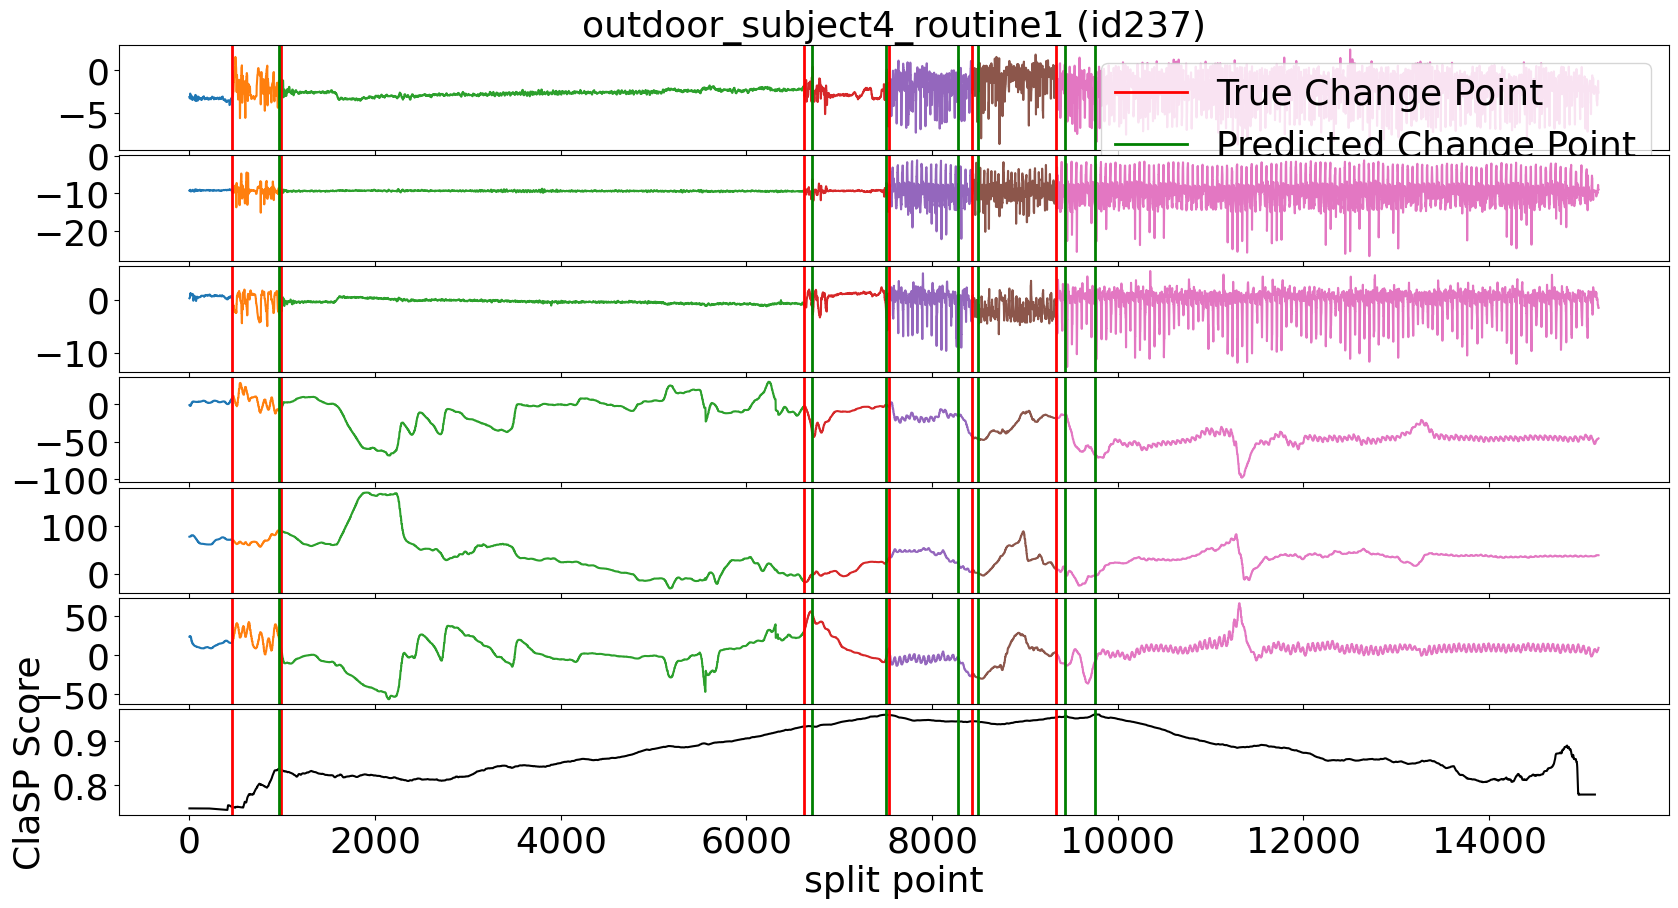

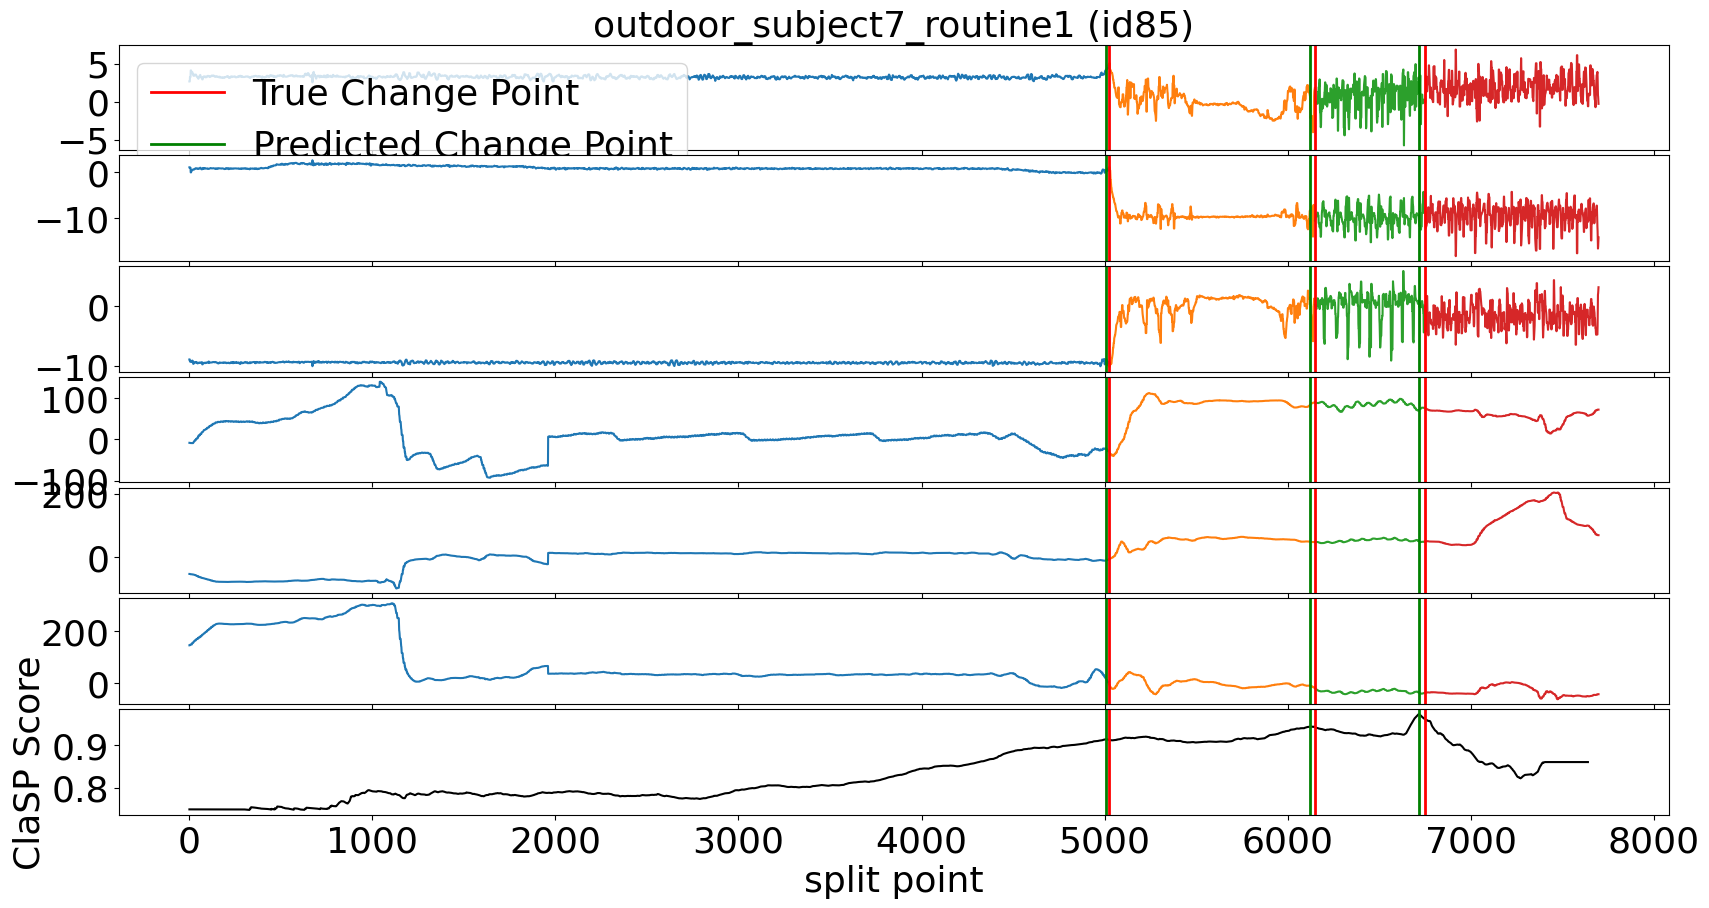

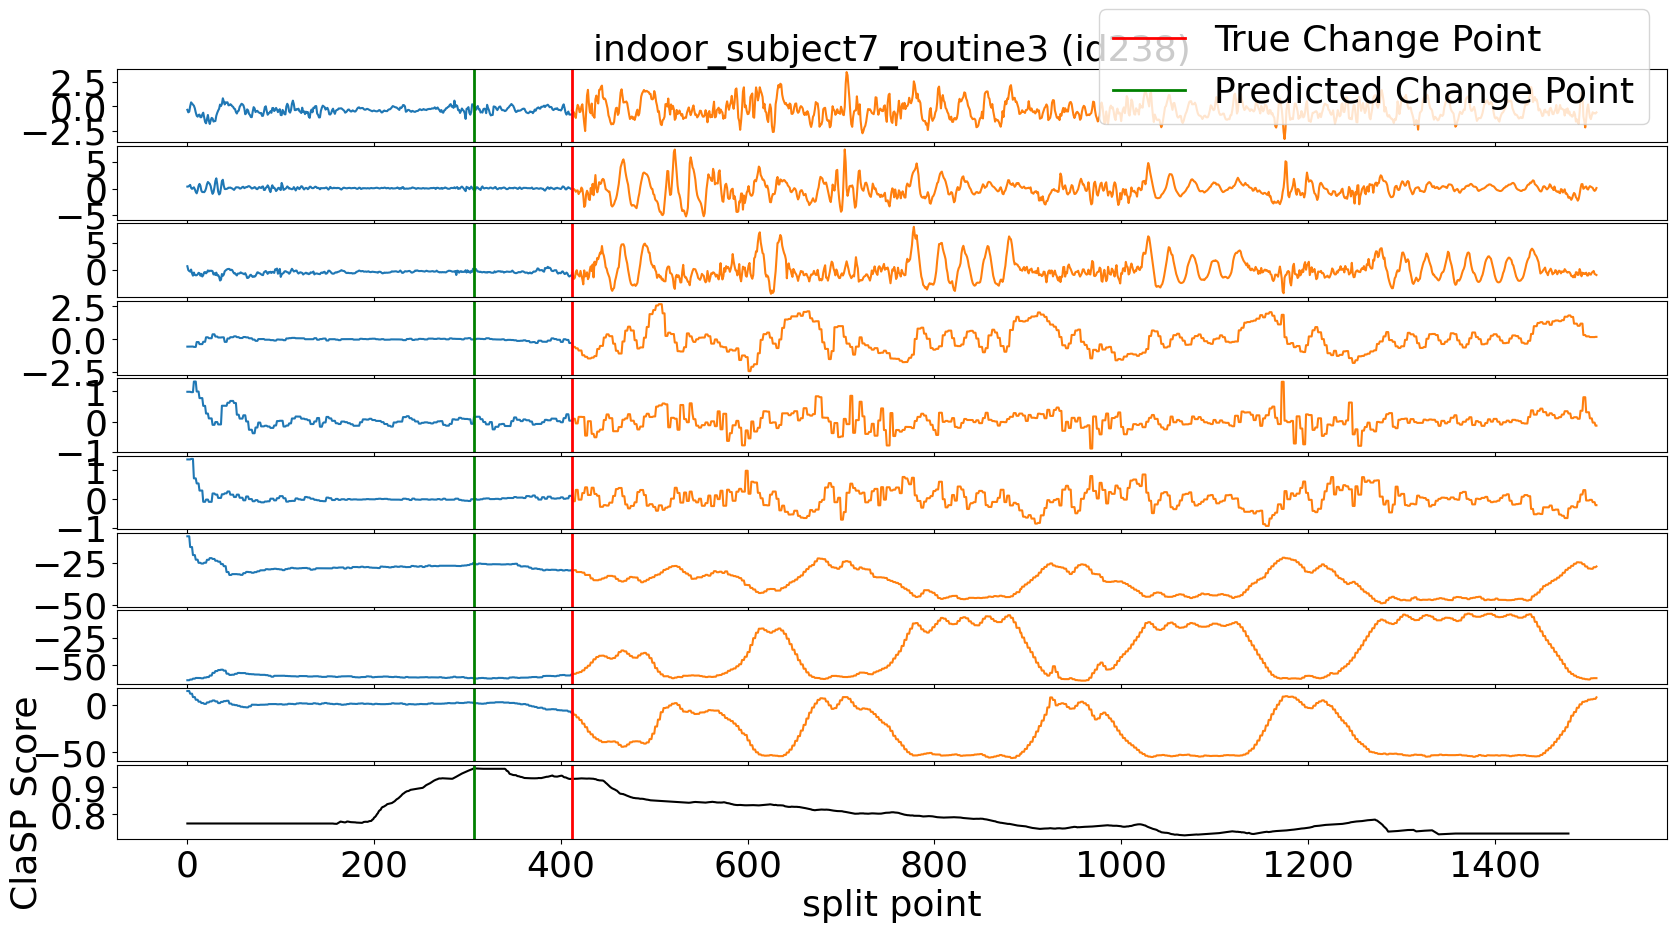

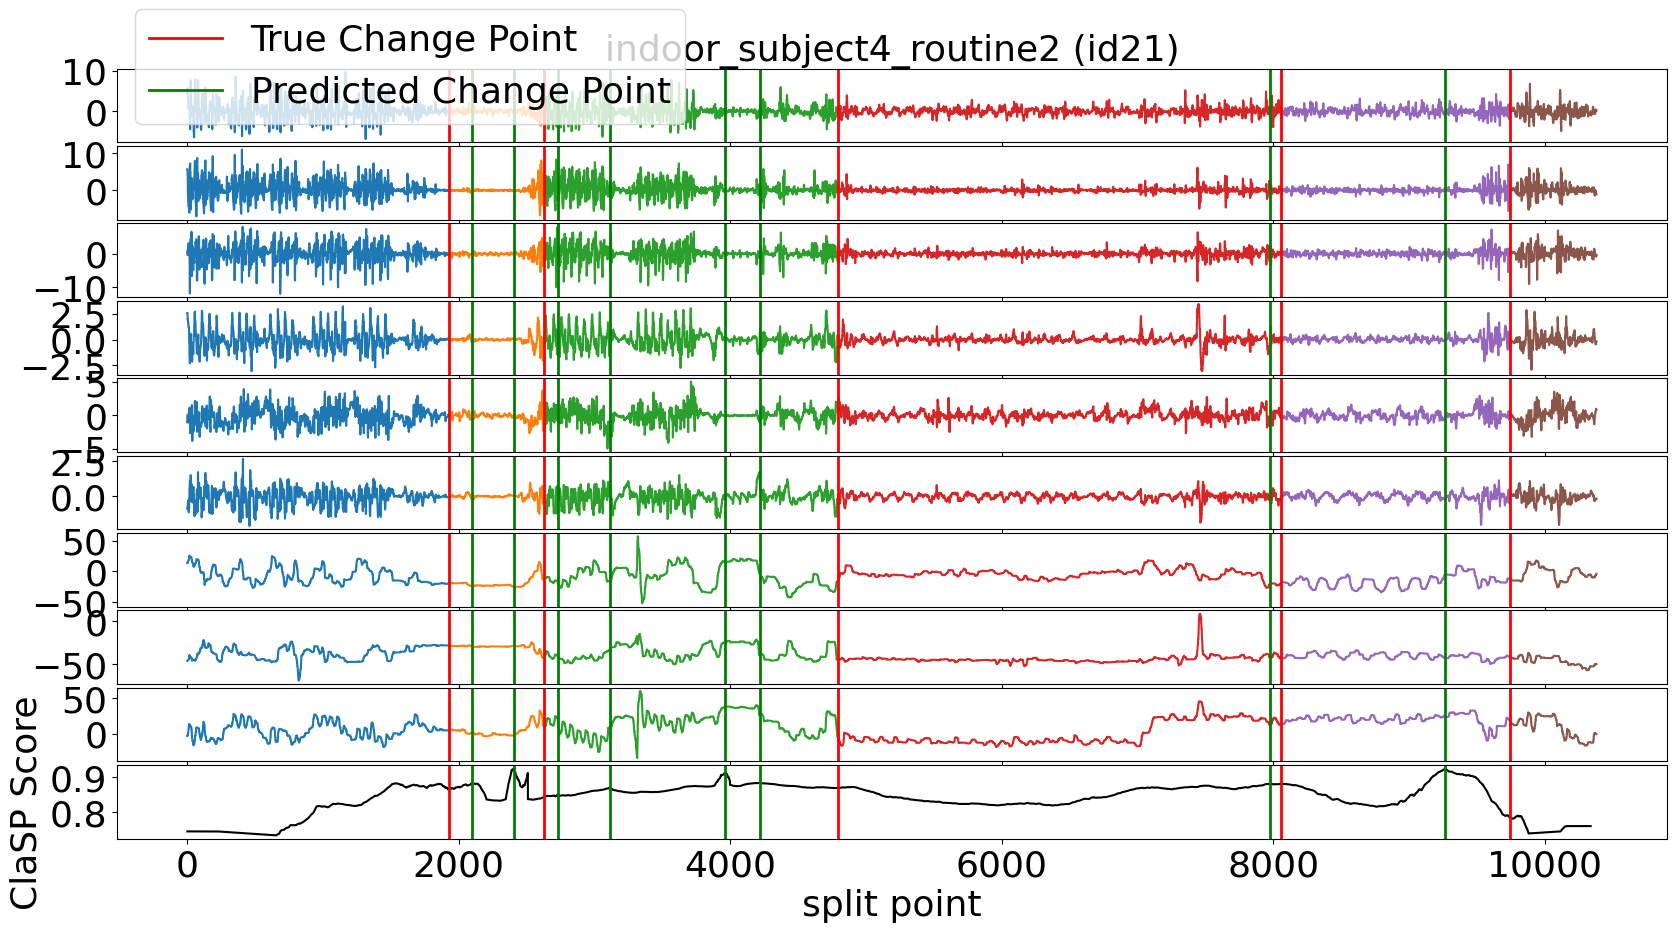

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


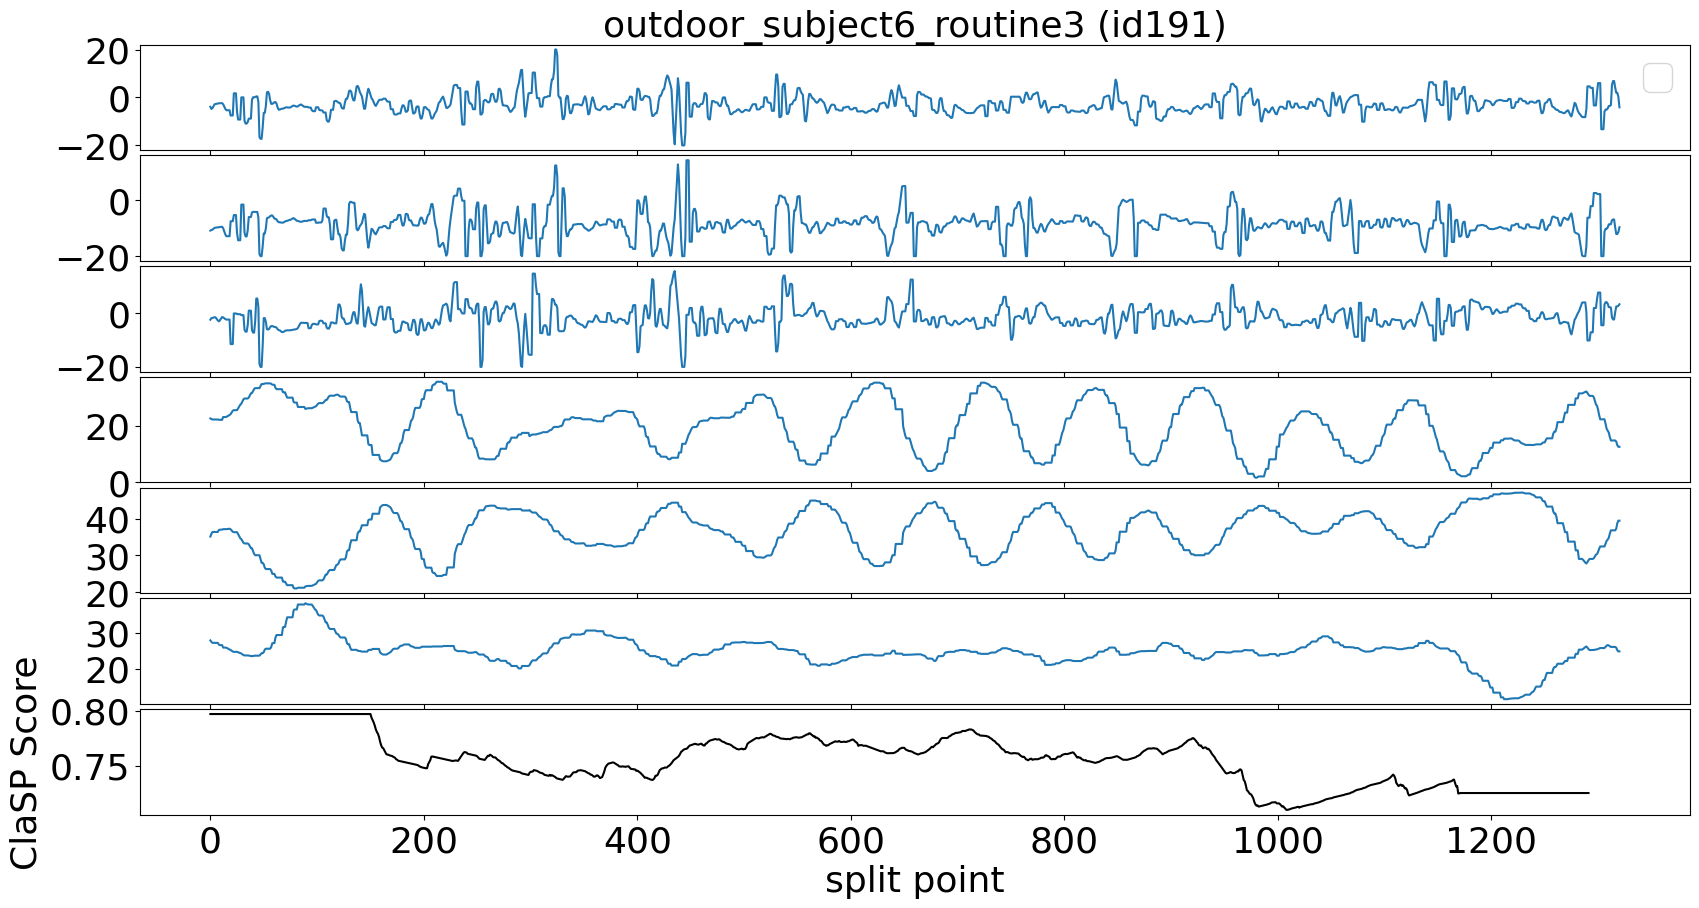

In [29]:
np.random.seed(2357)
for _, row in df.sample(5).iterrows():
    clasp = BinaryClaSPSegmentation().fit(row.time_series)
    clasp.plot(gt_cps=row.cps, heading=row.dataset)
    plt.show()

Lastly, we investigate the scalability of ClaSP.

In [25]:
df_scale = results.copy()
df_scale["len"] = df.time_series.apply(len).to_numpy()
df_scale["cps"] = df.cps.apply(len).to_numpy()
df_scale

,dataset,covering_score,runtime,len,cps
0,indoor_subject1_routine1 (id125),0.413,17.561,7791,5
1,indoor_subject1_routine1 (id140),0.648,14.587,8330,6
2,indoor_subject1_routine1 (id93),0.884,5.954,4964,5
3,indoor_subject1_routine1 (id52),0.429,4.104,4306,5
4,indoor_subject1_routine1 (id221),0.911,16.419,8371,5
...,...,...,...,...,...
245,outdoor_subject7_routine3 (id26),0.639,0.183,1303,0
246,outdoor_subject7_routine3 (id48),1.000,0.150,1434,0
247,outdoor_subject7_routine3 (id78),0.636,0.481,2157,2
248,outdoor_subject7_routine3 (id163),1.000,0.144,1351,0


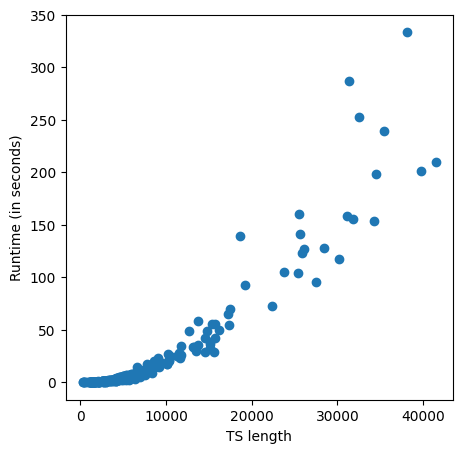

In [26]:
_, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(df_scale.len, df_scale.runtime)
ax.set_xlabel("TS length")
ax.set_ylabel("Runtime (in seconds)")
plt.show()

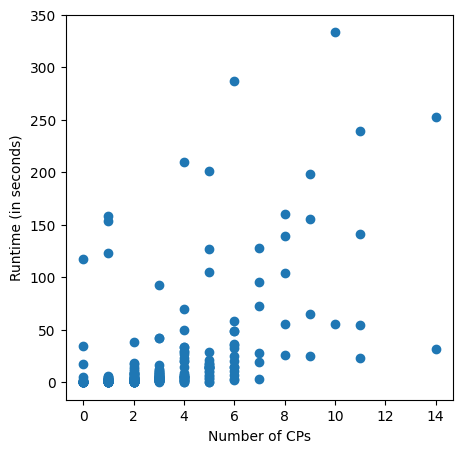

In [27]:
_, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(df_scale.cps, df_scale.runtime)
ax.set_xlabel("Number of CPs")
ax.set_ylabel("Runtime (in seconds)")
plt.show()

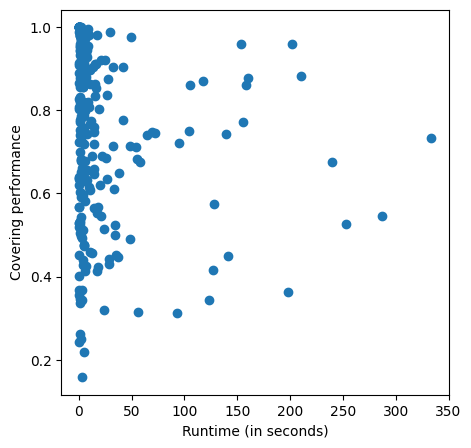

In [28]:
_, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(df_scale.runtime, df_scale.covering_score)
ax.set_xlabel("Runtime (in seconds)")
ax.set_ylabel("Covering performance")
plt.show()